In [13]:
# Get all the imports
import pandas as pd
import seaborn as sns
import numpy as np
import cv2
import keras
import matplotlib.pyplot as plt
import glob
import os
from sklearn.utils import shuffle

%matplotlib inline


In [14]:
data_folder = 'C://Users/scott/vm/b_cloning/'
log_file_name = 'driving_log.csv'
image_folder_name = 'IMG'
print(keras.__version__)

1.2.2


In [15]:
driving_log_df = pd.read_csv(os.path.join(data_folder, log_file_name), header=None)
driving_log_df.columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

In [16]:
#driving_log_df.center = driving_log_df.apply(lambda x: x['center'].replace('/Users/vmandal/Desktop/b_cloning', 'C://Users/scott/vm/data/'), axis=1)
#driving_log_df.left = driving_log_df.apply(lambda x: x['left'].replace('/Users/vmandal/Desktop/b_cloning', 'C://Users/scott/vm/data/'), axis=1)
#driving_log_df.right = driving_log_df.apply(lambda x: x['right'].replace('/Users/vmandal/Desktop/b_cloning', 'C://Users/scott/vm/data/'), axis=1)
driving_log_df.tail()

,center,left,right,steering,throttle,brake,speed
9121,C:\Users\scott\vm\b_cloning\IMG\center_2017_07...,C:\Users\scott\vm\b_cloning\IMG\left_2017_07_2...,C:\Users\scott\vm\b_cloning\IMG\right_2017_07_...,-0.500000,1.0,0.0,30.14478
9122,C:\Users\scott\vm\b_cloning\IMG\center_2017_07...,C:\Users\scott\vm\b_cloning\IMG\left_2017_07_2...,C:\Users\scott\vm\b_cloning\IMG\right_2017_07_...,-0.353364,1.0,0.0,30.18462
9123,C:\Users\scott\vm\b_cloning\IMG\center_2017_07...,C:\Users\scott\vm\b_cloning\IMG\left_2017_07_2...,C:\Users\scott\vm\b_cloning\IMG\right_2017_07_...,-0.162289,1.0,0.0,30.19391
9124,C:\Users\scott\vm\b_cloning\IMG\center_2017_07...,C:\Users\scott\vm\b_cloning\IMG\left_2017_07_2...,C:\Users\scott\vm\b_cloning\IMG\right_2017_07_...,0.000000,1.0,0.0,30.18607
9125,C:\Users\scott\vm\b_cloning\IMG\center_2017_07...,C:\Users\scott\vm\b_cloning\IMG\left_2017_07_2...,C:\Users\scott\vm\b_cloning\IMG\right_2017_07_...,0.000000,1.0,0.0,29.71594


In [17]:
driving_log_df.shape

(9126, 7)

In [18]:
# It plots the histogram of an arrray of angles: [0.0,0.1, ..., -0.1]
def plot_steering_histogram(steerings, title, num_bins=100):
    plt.hist(steerings, num_bins)
    plt.title(title)
    plt.xlabel('Steering Angles')
    plt.ylabel('# Images')
    plt.show()

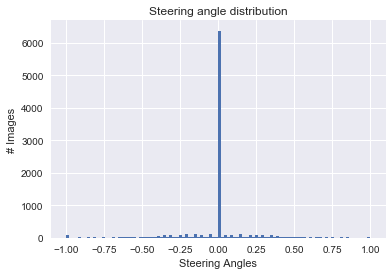

In [19]:
plot_steering_histogram(driving_log_df.steering, 'Steering angle distribution')

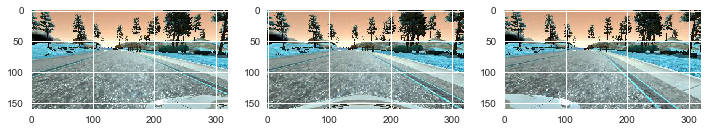

In [20]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 8))
img = cv2.imread('C://Users/scott/vm/data/IMG/left_2017_07_17_10_19_55_515.jpg', 1)
axes[0].imshow(img)

img = cv2.imread('C://Users/scott/vm/data/IMG/center_2017_07_17_10_19_55_515.jpg', cv2.COLOR_RGB2BGR)
axes[1].imshow(img)

img = cv2.imread('C://Users/scott/vm/data/IMG/right_2017_07_17_10_19_55_515.jpg', cv2.COLOR_RGB2BGR)
axes[2].imshow(img)

In [21]:
# Preprocessing and Augmentation
def load(img_path):
    return cv2.imread(img_path)

def rgb_to_yuv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

def crop_img(img):
    return img[50:-20, :, :]

def adj_brightness(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    factor = 0.4 + np.random.uniform(0,0.6)
    hsv[:,:,2] =  hsv[:,:,2] * factor
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

def rand_flip(img, steering_angle):
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering_angle = -steering_angle
    return img, steering_angle

def rand_translate(img, steering_angle, x_range=50.0, y_range=5.0):
    x_trans = x_range * np.random.uniform() - x_range/2.0
    y_trans = y_range * np.random.uniform() - y_range/2.0
    
    trans_mat = np.float32([[1, 0, x_trans], [0, 1, y_trans]])
    r, c, b = img.shape
    
    img_trans = cv2.warpAffine(img, trans_mat, (c, r))
    
    steering_angle += x_trans / x_range * 0.2
    
    return img_trans, steering_angle

def pick_image(left_img_path, right_img_path, center_img_path, steering_angle):
    
    choice = np.random.choice(3)
    
    if choice == 0:
        return load(left_img_path), steering_angle + 0.2
    if choice == 1:
        return load(right_img_path), steering_angle - 0.2
    return load(center_img_path), steering_angle

def resize(img):
    return cv2.resize(img, (200, 66), interpolation = cv2.INTER_AREA)

def augment(center_img_path, left_img_path, right_img_path, steering_angle):
    img, steering_angle = pick_image(left_img_path, right_img_path, center_img_path, steering_angle)
    img, steering_angle = rand_flip(img, steering_angle)
    img, steering_angle = rand_translate(img, steering_angle)
    img = adj_brightness(img)
    return img, steering_angle

def preprocess_img(img):
    img = crop_img(img)
    img = resize(img)
    img = rgb_to_yuv(img)
    return img

def generate_data(image_paths, angles, batch_size=20, is_validation=False):
    '''
    method for loading, processing, and distorting images
    if 'validation_flag' is true the image is not distorted
    '''
    X = []
    y = []
    image_paths, angles = shuffle(image_paths, angles)
    while True:
        for i in range(batch_size):
            c, l, r = image_paths[i]
            angle = angles[i]
            
            if not is_validation:
                img, angle = augment(c, l, r, angle)
            else:
                img = load(c)
            img = preprocess_img(img)
            X.append(img)
            y.append(angle)
        yield (np.array(X), np.array(y))
    


In [22]:
image_paths = list(zip(driving_log_df.center.tolist(),
                       driving_log_df.left.tolist(),
                       driving_log_df.right.tolist()))
angles = driving_log_df.steering.tolist()

X_train, y_train = next(generate_data(image_paths, angles, batch_size=7000))

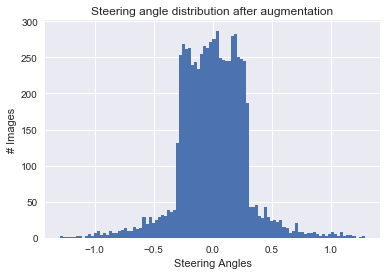

In [23]:
plot_steering_histogram(y_train, 'Steering angle distribution after augmentation')

In [27]:
from keras.models import Sequential, Model
from keras.layers.core import Lambda, Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Cropping2D, Convolution2D, Conv2D
from keras.layers.advanced_activations import ELU
from keras.layers.noise import GaussianNoise
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
 
print("\nBuilding and compiling the model ...")

if True:
    '''
    model = Sequential()

    # Normalize
    model.add(Lambda(lambda x: x/127.5 - 1.0,input_shape=(66,200,3)))

    # Add three 5x5 convolution layers (output depth 24, 36, and 48), each with 2x2 stride
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode='valid', W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='valid', W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode='valid', W_regularizer=l2(0.001)))
    model.add(ELU())

    #model.add(Dropout(0.50))
    
    # Add two 3x3 convolution layers (output depth 64, and 64)
    model.add(Convolution2D(64, 3, 3, border_mode='valid', W_regularizer=l2(0.001)))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, border_mode='valid', W_regularizer=l2(0.001)))
    model.add(ELU())

    # Add a flatten layer
    model.add(Flatten())

    # Add three fully connected layers (depth 100, 50, 10), tanh activation (and dropouts)
    model.add(Dense(100, W_regularizer=l2(0.001)))
    model.add(ELU())
    #model.add(Dropout(0.50))
    model.add(Dense(50, W_regularizer=l2(0.001)))
    model.add(ELU())
    #model.add(Dropout(0.50))
    model.add(Dense(10, W_regularizer=l2(0.001)))
    model.add(ELU())
    #model.add(Dropout(0.50))

    # Add a fully connected output layer
    model.add(Dense(1))
    '''
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=(66, 200, 3)))
    model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(64, 3, 3, activation='elu'))
    model.add(Conv2D(64, 3, 3, activation='elu'))
    model.add(Dropout(.5))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    model.summary()
    


Building and compiling the model ...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 66, 200, 3)    0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
convolution2d_16 (Convolution2D) (None, 31, 98, 24)    1824        lambda_4[0][0]                   
____________________________________________________________________________________________________
convolution2d_17 (Convolution2D) (None, 14, 47, 36)    21636       convolution2d_16[0][0]           
____________________________________________________________________________________________________
convolution2d_18 (Convolution2D) (None, 5, 22, 48)     43248       convolution2d_17[0][0]           
_____________________________________________________

In [33]:
from sklearn.model_selection import train_test_split

BATCH_SIZE = 32
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, angles, test_size=0.2, random_state=0)

#checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
#                                 monitor='val_loss',
#                                 verbose=0,
#                                 save_best_only=args.save_best_only,
#                                 mode='auto')
checkpoint = ModelCheckpoint('model{epoch:02d}.h5')

model.compile(loss='mean_squared_error', optimizer=Adam(lr=1.0e-4))

model.fit_generator(generate_data(X_train, y_train, batch_size=BATCH_SIZE),
                        samples_per_epoch=16000,
                        nb_epoch=15,
                        max_q_size=1,
                        validation_data=generate_data(X_valid, y_valid, batch_size=BATCH_SIZE, is_validation=True),
                        nb_val_samples=len(X_valid),
                        callbacks=[checkpoint],
                        verbose=1)

print('Training Complete!')

Epoch 1/15
15872/16000 [============================>.] - ETA: 0s - loss: 0.0286

C:\ProgramData\Anaconda3\lib\site-packages\keras-1.2.2-py3.6.egg\keras\engine\training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


16896/16000 [===============================] - 7s - loss: 0.0284 - val_loss: 0.0154
Epoch 2/15
16224/16000 [==============================] - 4s - loss: 0.0246 - val_loss: 0.0163
Epoch 3/15
16160/16000 [==============================] - 4s - loss: 0.0232 - val_loss: 0.0174
Epoch 4/15
17280/16000 [================================] - 4s - loss: 0.0224 - val_loss: 0.0178
Epoch 5/15
17536/16000 [================================] - 5s - loss: 0.0216 - val_loss: 0.0193
Epoch 6/15
17024/16000 [===============================] - 4s - loss: 0.0212 - val_loss: 0.0198
Epoch 7/15
18592/16000 [==================================] - 5s - loss: 0.0208 - val_loss: 0.0205
Epoch 8/15
17184/16000 [================================] - 4s - loss: 0.0201 - val_loss: 0.0213
Epoch 9/15
18336/16000 [==================================] - 5s - loss: 0.0202 - val_loss: 0.0216
Epoch 10/15
16160/16000 [==============================] - 4s - loss: 0.0199 - val_loss: 0.0222
Epoch 11/15
 6688/16000 [===========>.......

ResourceExhaustedError: OOM when allocating tensor with shape[3392,24,31,98]
	 [[Node: gradients_4/Conv2D_16_grad/Conv2DBackpropInput = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@Conv2D_16"], data_format="NHWC", padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](gradients_4/Conv2D_16_grad/Shape, convolution2d_17_W/read, gradients_4/add_83_grad/Reshape)]]

Caused by op 'gradients_4/Conv2D_16_grad/Conv2DBackpropInput', defined at:
  File "C:\ProgramData\Anaconda3\Lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\Lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-51b39698d7f8>", line 22, in <module>
    verbose=1)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-1.2.2-py3.6.egg\keras\models.py", line 935, in fit_generator
    initial_epoch=initial_epoch)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-1.2.2-py3.6.egg\keras\engine\training.py", line 1454, in fit_generator
    self._make_train_function()
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-1.2.2-py3.6.egg\keras\engine\training.py", line 760, in _make_train_function
    self.total_loss)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-1.2.2-py3.6.egg\keras\optimizers.py", line 416, in get_updates
    grads = self.get_gradients(loss, params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-1.2.2-py3.6.egg\keras\optimizers.py", line 82, in get_gradients
    grads = K.gradients(loss, params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-1.2.2-py3.6.egg\keras\backend\tensorflow_backend.py", line 1968, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 540, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 346, in _MaybeCompile
    return grad_fn()  # Exit early
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py", line 540, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_grad.py", line 445, in _Conv2DGrad
    op.get_attr("data_format")),
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 488, in conv2d_backprop_input
    data_format=data_format, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

...which was originally created as op 'Conv2D_16', defined at:
  File "C:\ProgramData\Anaconda3\Lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-1e86824db90d>", line 55, in <module>
    model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-1.2.2-py3.6.egg\keras\models.py", line 332, in add
    output_tensor = layer(self.outputs[0])
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-1.2.2-py3.6.egg\keras\engine\topology.py", line 572, in __call__
    self.add_inbound_node(inbound_layers, node_indices, tensor_indices)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-1.2.2-py3.6.egg\keras\engine\topology.py", line 635, in add_inbound_node
    Node.create_node(self, inbound_layers, node_indices, tensor_indices)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-1.2.2-py3.6.egg\keras\engine\topology.py", line 166, in create_node
    output_tensors = to_list(outbound_layer.call(input_tensors[0], mask=input_masks[0]))
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-1.2.2-py3.6.egg\keras\layers\convolutional.py", line 475, in call
    filter_shape=self.W_shape)
  File "C:\ProgramData\Anaconda3\lib\site-packages\keras-1.2.2-py3.6.egg\keras\backend\tensorflow_backend.py", line 2691, in conv2d
    x = tf.nn.conv2d(x, kernel, strides, padding=padding)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 399, in conv2d
    data_format=data_format, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3392,24,31,98]
	 [[Node: gradients_4/Conv2D_16_grad/Conv2DBackpropInput = Conv2DBackpropInput[T=DT_FLOAT, _class=["loc:@Conv2D_16"], data_format="NHWC", padding="VALID", strides=[1, 2, 2, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](gradients_4/Conv2D_16_grad/Shape, convolution2d_17_W/read, gradients_4/add_83_grad/Reshape)]]


In [ ]:
import json
model.save_weights('./model.h5')
json_string = model.to_json()
with open('./model.json', 'w') as f:
    f.write(json_string)

In [17]:
from keras.models import model_from_json
with open('./model.json', 'r') as f:
    model_from_json(f.read())